<a href="https://colab.research.google.com/github/tancik/fourier-feature-networks/blob/master/Experiments/1d_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# !pip install -qq neural_tangents==0.2.2

In [13]:
import jax
from jax import random, grad, jit, vmap
from jax.config import config
from jax.lib import xla_bridge
import jax.numpy as np
import neural_tangents as nt
from neural_tangents import stax
from jax.example_libraries import optimizers
import jax.numpy as jnp

import os

import matplotlib
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Circle
from tqdm.notebook import tqdm as tqdm

import time

import numpy as onp

/tmp/ipykernel_3130133/2706731140.py:3: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [14]:
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5,6,7"  # For example, to use only the first GPU

In [15]:
# Utils

fplot = lambda x: np.fft.fftshift(np.log10(np.abs(np.fft.fft(x))))

# Signal makers


def sample_random_signal(key, decay_vec):
    N = decay_vec.shape[0]
    raw = random.normal(key, [N, 2]) @ np.array([1, 1j])
    signal_f = raw * decay_vec
    signal = np.real(np.fft.ifft(signal_f))
    return signal


def sample_random_powerlaw(key, N, power):
    coords = np.float32(
        np.fft.ifftshift(1 + N // 2 - np.abs(np.fft.fftshift(np.arange(N)) - N // 2))
    )
    decay_vec = coords**-power
    decay_vec = onp.array(decay_vec)
    decay_vec[N // 4 :] = 0
    return sample_random_signal(key, decay_vec)


# Network


def make_network(num_layers, num_channels, ntk_params=True, num_outputs=1):
    layers = []
    for i in range(num_layers - 1):
        if ntk_params:
            layers.append(stax.Dense(num_channels, parameterization="standard"))
        else:
            layers.append(stax.Dense(num_channels, parameterization="standard"))

        layers.append(stax.Relu())
    layers.append(stax.Dense(num_outputs, parameterization="standard"))
    return stax.serial(*layers)


# Encoding


def compute_ntk(x, avals, bvals, kernel_fn):
    x1_enc = input_encoder(x, avals, bvals)
    x2_enc = input_encoder(np.array([0.0], dtype=np.float32), avals, bvals)
    out = np.squeeze(kernel_fn(x1_enc, x2_enc, "ntk"))
    return out


input_encoder = lambda x, a, b: np.concatenate(
    [
        a * np.sin((2.0 * np.pi * x[..., None]) * b),
        a * np.cos((2.0 * np.pi * x[..., None]) * b),
    ],
    axis=-1,
) / np.linalg.norm(a)


def predict_psnr_basic(
    kernel_fn, train_fx, test_fx, train_x, train_y, test_x, test_y, t_final, eta=None
):
    g_dd = kernel_fn(train_x, train_x, "ntk")
    g_td = kernel_fn(test_x, train_x, "ntk")
    train_predict_fn = nt.predict.gradient_descent_mse(g_dd, train_y[..., None])
    train_theory_y, test_theory_y = train_predict_fn(
        t=t_final,
        fx_train_0=train_fx[..., None],
        fx_test_0=test_fx[..., None],
        k_test_train=g_td,  # NOTE: check whether this is correct?????
    )

    calc_psnr = lambda f, g: -10.0 * np.log10(np.mean((f - g) ** 2))
    return calc_psnr(test_y, test_theory_y[:, 0]), calc_psnr(
        train_y, train_theory_y[:, 0]
    )


predict_psnr_basic = jit(predict_psnr_basic, static_argnums=(0,))


def train_model(
    rand_key,
    network_size,
    lr,
    iters,
    train_input,
    test_input,
    test_mask,
    optimizer,
    ab,
    name="",
):
    if ab is None:
        ntk_params = False
    else:
        ntk_params = True
    init_fn, apply_fn, kernel_fn = make_network(*network_size, ntk_params=ntk_params)

    if ab is None:
        run_model = jit(
            lambda params, ab, x: np.squeeze(apply_fn(params, x[..., None] - 0.5))
        )
    else:
        run_model = jit(
            lambda params, ab, x: np.squeeze(apply_fn(params, input_encoder(x, *ab)))
        )
    model_loss = jit(
        lambda params, ab, x, y: 0.5 * np.sum((run_model(params, ab, x) - y) ** 2)
    )
    model_psnr = jit(
        lambda params, ab, x, y: -10
        * np.log10(np.mean((run_model(params, ab, x) - y) ** 2))
    )
    model_grad_loss = jit(
        lambda params, ab, x, y: jax.grad(model_loss)(params, ab, x, y)
    )

    opt_init, opt_update, get_params = optimizer(lr)
    opt_update = jit(opt_update)

    if ab is None:
        _, params = init_fn(rand_key, (-1, 1))
    else:
        _, params = init_fn(
            rand_key, (-1, input_encoder(train_input[0], *ab).shape[-1])
        )
    opt_state = opt_init(params)

    pred0 = run_model(get_params(opt_state), ab, test_input[0])
    pred0_f = np.fft.fft(pred0)

    train_psnrs = []
    test_psnrs = []
    theories = []
    xs = []
    errs = []
    for i in tqdm(range(iters), desc=name):
        opt_state = opt_update(
            i, model_grad_loss(get_params(opt_state), ab, *train_input), opt_state
        )

        if i % 20 == 0:
            train_psnr = model_psnr(get_params(opt_state), ab, *train_input)
            test_psnr = model_psnr(
                get_params(opt_state),
                ab,
                test_input[0][test_mask],
                test_input[1][test_mask],
            )
            if ab is None:
                train_fx = run_model(get_params(opt_state), ab, train_input[0])
                test_fx = run_model(get_params(opt_state), ab, test_input[0][test_mask])
                theory = predict_psnr_basic(
                    kernel_fn,
                    train_fx,
                    test_fx,
                    train_input[0][..., None] - 0.5,
                    train_input[1],
                    test_input[0][test_mask][..., None],
                    test_input[1][test_mask],
                    i * lr,
                )
            else:
                test_x = input_encoder(test_input[0][test_mask], *ab)
                train_x = input_encoder(train_input[0], *ab)

                train_fx = run_model(get_params(opt_state), ab, train_input[0])
                test_fx = run_model(get_params(opt_state), ab, test_input[0][test_mask])
                theory = predict_psnr_basic(
                    kernel_fn,
                    train_fx,
                    test_fx,
                    train_x,
                    train_input[1],
                    test_x,
                    test_input[1][test_mask],
                    i * lr,
                )

            train_psnrs.append(train_psnr)
            test_psnrs.append(test_psnr)
            theories.append(theory)
            pred = run_model(get_params(opt_state), ab, train_input[0])
            errs.append(pred - train_input[1])
            xs.append(i)
    return get_params(opt_state), train_psnrs, test_psnrs, errs, np.array(theories), xs

# Make fig 2

In [16]:
N_train = 32
data_power = 1

network_size = (4, 1024)

learning_rate = 1e-5
sgd_iters = 50001

In [17]:
rand_key = random.PRNGKey(0)

config.update("jax_disable_jit", False)

# Signal
M = 8
N = N_train
x_test = np.float32(np.linspace(0, 1.0, N * M, endpoint=False))
x_train = x_test[::M]

test_mask = onp.ones(len(x_test), onp.bool_)
test_mask[np.arange(0, x_test.shape[0], M)] = 0

s = sample_random_powerlaw(rand_key, N * M, data_power)
s = (s - s.min()) / (s.max() - s.min()) - 0.5

# Kernels
bvals = np.float32(np.arange(1, N // 2 + 1))
ab_dict = {}
# ab_dict = {r'$p = {}$'.format(p) : (bvals**-np.float32(p), bvals) for p in [0, 1]}
ab_dict = {
    r"$p = {}$".format(p): (bvals ** -np.float32(p), bvals) for p in [0, 0.5, 1, 1.5, 2]
}
ab_dict[r"$p = \infty$"] = (np.eye(bvals.shape[0])[0], bvals)
ab_dict["No mapping"] = None


# Train the networks

rand_key, *ensemble_key = random.split(rand_key, 1 + len(ab_dict))

outputs = {
    k: train_model(
        key,
        network_size,
        learning_rate,
        sgd_iters,
        (x_train, s[::M]),
        (x_test, s),
        test_mask,
        optimizer=optimizers.sgd,
        ab=ab_dict[k],
        name=k,
    )
    for k, key in zip(ab_dict, ensemble_key)
}

ab_dict.update(
    {r"$p = {}$".format(p): (bvals ** -np.float32(p), bvals) for p in [0.5, 1.5, 2]}
)

$p = 0$:   0%|          | 0/50001 [00:00<?, ?it/s]

$p = 0.5$:   0%|          | 0/50001 [00:00<?, ?it/s]

$p = 1$:   0%|          | 0/50001 [00:00<?, ?it/s]

$p = 1.5$:   0%|          | 0/50001 [00:00<?, ?it/s]

$p = 2$:   0%|          | 0/50001 [00:00<?, ?it/s]

$p = \infty$:   0%|          | 0/50001 [00:00<?, ?it/s]

No mapping:   0%|          | 0/50001 [00:00<?, ?it/s]

# Fig 2

/tmp/ipykernel_3130133/1195609538.py:56: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = fig3.add_subplot(gs[0, 0])
/tmp/ipykernel_3130133/1195609538.py:69: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = fig3.add_subplot(gs[0, 1])
/tmp/ipykernel_3130133/1195609538.py:78: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = fig3.add_subplot(gs[0, 2])
/tmp/ipykernel_3130133/1195609538.py:97: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = fig3.add_subplot(gs[0, 3])


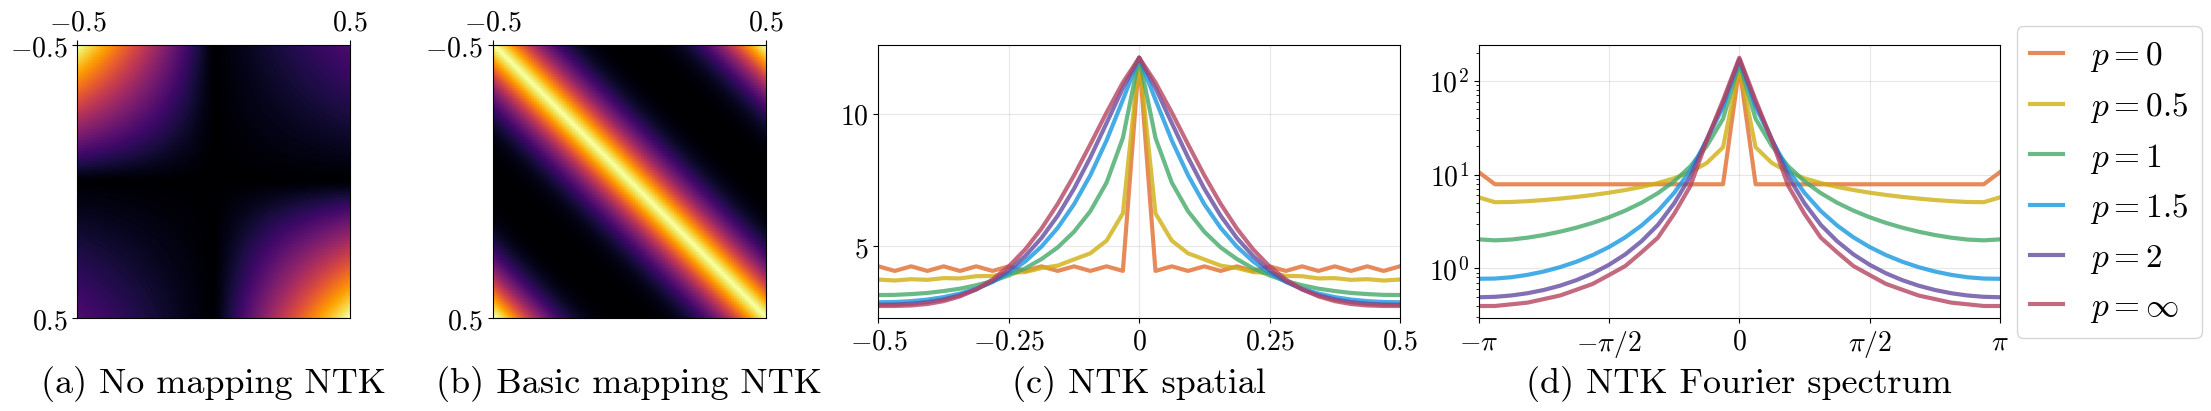

In [18]:
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]


params = {
    "legend.fontsize": 24,
    "axes.labelsize": 22,
    "axes.titlesize": 26,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
}
pylab.rcParams.update(params)


matplotlib.rcParams["mathtext.fontset"] = "cm"
matplotlib.rcParams["mathtext.rm"] = "serif"

plt.rcParams["font.family"] = "cmr10"
names = ["$p = 0$", "$p = 0.5$", "$p = 1$", "$p = 1.5$", "$p = 2$", "$p = \\infty$"]

N_kernels = len(names)

colors_k = [
    [0.8872, 0.4281, 0.1875],
    [0.8136, 0.6844, 0.0696],
    [0.2634, 0.6634, 0.4134],
    [0.0943, 0.5937, 0.8793],
    [0.3936, 0.2946, 0.6330],
    [0.7123, 0.2705, 0.3795],
]
linewidth = 3
line_alpha = 0.8
title_offset = -0.3

xs = outputs[names[0]][-1]
t_final = learning_rate * sgd_iters

init_fn, apply_fn, kernel_fn = make_network(*network_size)
run_model = jit(
    lambda params, ab, x: np.squeeze(apply_fn(params, input_encoder(x, *ab)))
)

fig3 = plt.figure(constrained_layout=True, figsize=(22, 4))
gs = fig3.add_gridspec(1, 4, width_ratios=[1, 1, 1.3, 1.3])

### Plot NTK stuff

H_rows = {k: compute_ntk(x_train, *ab_dict[k], kernel_fn) for k in names}

samples = 100
x_no_encoding = np.linspace(-np.pi, np.pi, samples)
x_basic = np.stack([np.sin(x_no_encoding), np.cos(x_no_encoding)], axis=-1)
relu_NTK = kernel_fn(x_no_encoding[:, None], x_no_encoding[:, None], "ntk")
basic_NTK = kernel_fn(x_basic, x_basic, "ntk")

ax = fig3.add_subplot(gs[0, 0])
ax.imshow(relu_NTK, cmap="inferno", extent=[-0.5, 0.5, 0.5, -0.5])
ax.xaxis.tick_top()
extent = [-0.5, 0.5]
ax.set_xticks([-0.5, 0.5])
ax.set_yticks([-0.5, 0.5])
ax.set_xticklabels([rf"${t:g}$" for t in extent])
ax.set_yticklabels([rf"${t:g}$" for t in extent])
xtick = ax.get_xticks()
ax.set_xticks(xtick)
ax.set_xticklabels([rf"${t:g}$" for t in xtick])
ax.set_title("(a) No mapping NTK", y=title_offset)

ax = fig3.add_subplot(gs[0, 1])
ax.imshow(basic_NTK, cmap="inferno", extent=[-0.5, 0.5, 0.5, -0.5])
ax.xaxis.tick_top()
ax.set_xticks([-0.5, 0.5])
ax.set_yticks([-0.5, 0.5])
ax.set_xticklabels([rf"${t:g}$" for t in extent])
ax.set_yticklabels([rf"${t:g}$" for t in extent])
ax.set_title("(b) Basic mapping NTK", y=title_offset)

ax = fig3.add_subplot(gs[0, 2])
for c, k in zip(colors_k, H_rows):
    ntk_spatial = np.fft.fftshift(H_rows[k])
    ax.plot(
        np.linspace(-0.5, 0.5, 33, endpoint=True),
        np.append(ntk_spatial, ntk_spatial[0]),
        label=k,
        color=c,
        alpha=line_alpha,
        linewidth=linewidth,
    )
ax.set_title("(c) NTK spatial", y=title_offset)
xtick = ax.get_xticks()
ax.set_xticks(xtick)
ax.set_xticklabels([rf"${t:g}$" for t in xtick])

plt.grid(True, which="both", alpha=0.3)
plt.autoscale(enable=True, axis="x", tight=True)

ax = fig3.add_subplot(gs[0, 3])
for c, k in zip(colors_k, H_rows):
    ntk_spectrum = 10 ** fplot(H_rows[k])
    plt.semilogy(
        np.append(ntk_spectrum, ntk_spectrum[0]),
        label=k,
        color=c,
        alpha=line_alpha,
        linewidth=linewidth,
    )
ax.set_title("(d) NTK Fourier spectrum", y=title_offset)
plt.xticks([0, 8, 16, 24, 32], ["$-\pi$", "$-\pi/2$", "$0$", "$\pi/2$", "$\pi$"])

plt.autoscale(enable=True, axis="x", tight=True)
plt.grid(True, which="major", alpha=0.3)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), handlelength=1)


plt.savefig("1D_fig2.pdf", bbox_inches="tight", pad_inches=0)

plt.show()

# Fig 3

/tmp/ipykernel_3130133/3280608039.py:70: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = fig3.add_subplot(gs[0:4, 0:6])
/tmp/ipykernel_3130133/3280608039.py:126: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = fig3.add_subplot(gs[3:6, 6:8])
/tmp/ipykernel_3130133/3280608039.py:168: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = fig3.add_subplot(gs[0:3, 6:8])
/tmp/ipykernel_3130133/3280608039.py:202: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = fig3.add_subplot(gs[4:6, 0 + 2 * i : 0 + 2 * i + 2])
/tmp/ipykernel_3130133/3280608039.py:202: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = fig3.add_subplot(gs[4:6, 0 + 2 * i : 0 + 2 * i + 2])
/tmp/ipykernel_3130133/3280608039.py:202: UserW

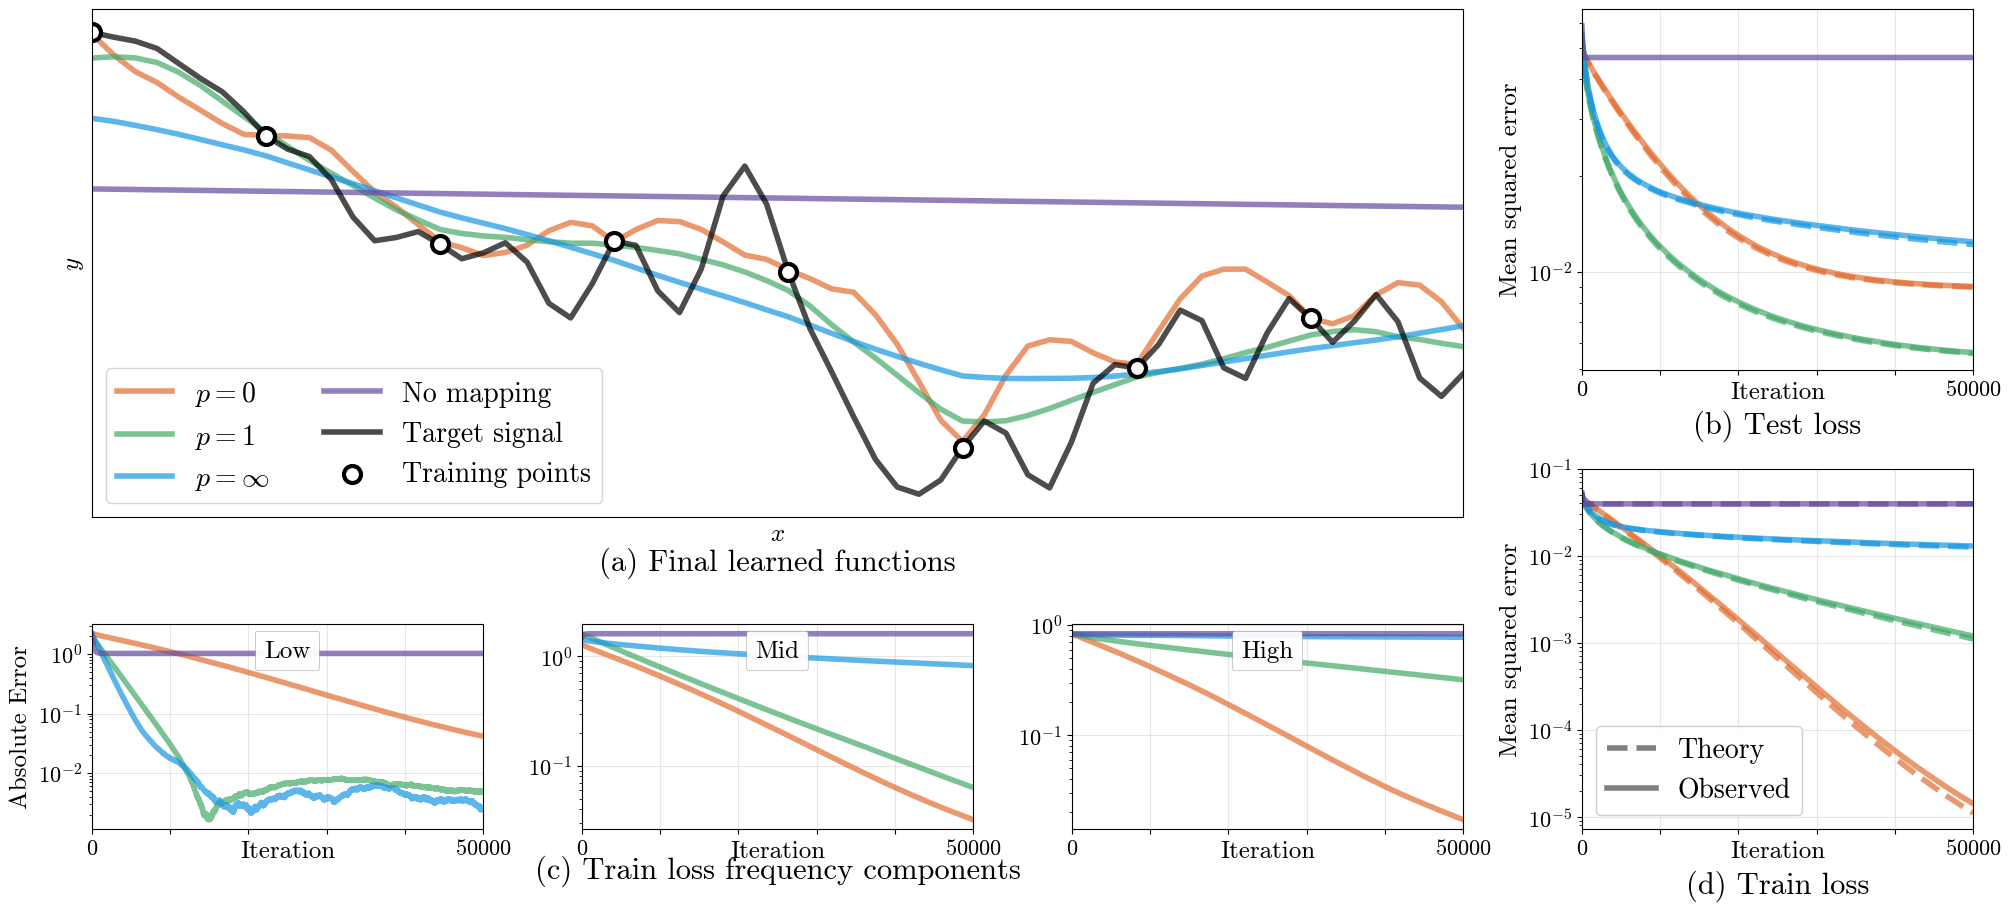

In [19]:
import matplotlib.patches as patches

prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

params = {
    "legend.fontsize": 20,
    "axes.labelsize": 18,
    "axes.titlesize": 22,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
}
pylab.rcParams.update(params)


matplotlib.rcParams["mathtext.fontset"] = "cm"
matplotlib.rcParams["mathtext.rm"] = "serif"

plt.rcParams["font.family"] = "cmr10"

names = list(outputs.keys())
names = [n for n in names if "opt" not in n]
names = [
    "$p = 0$",
    #  '$p = 0.5$',
    "$p = 1$",
    #  '$p = 1.5$',
    #  '$p = 2$',
    "$p = \\infty$",
    "No mapping",
]

N_kernels = len(names)
colors_k = [
    [0.8872, 0.4281, 0.1875],
    # [0.8136, 0.6844, 0.0696],
    [0.2634, 0.6634, 0.4134],
    [0.0943, 0.5937, 0.8793],
    [0.3936, 0.2946, 0.6330],
    [0.7123, 0.2705, 0.3795],
]
linewidth = 4
line_alpha = 0.7
title_offset = -0.2

xs = outputs[names[0]][-1]
t_final = learning_rate * sgd_iters

_, apply_fn, kernel_fn = make_network(*network_size)
_, apply_fn_standard, kernel_fn_standard = make_network(*network_size, ntk_params=False)
run_model = jit(
    lambda params, ab, x: np.squeeze(apply_fn(params, input_encoder(x, *ab)))
)

fig3 = plt.figure(constrained_layout=True, figsize=(20, 9))
gs = fig3.add_gridspec(6, 8)

H_rows = {
    k: compute_ntk(x_train, *ab_dict[k], kernel_fn)
    for k in names
    if k not in "No mapping"
}


### Plot learned fns
max_size = x_test.shape[0]
i0, i1 = 0.5, 0.75  ### These numbers are arbitrary, just taking a slice
i0 = (int(max_size * i0) // M) * M
i1 = (int(max_size * i1) // M) * M
ax = fig3.add_subplot(gs[0:4, 0:6])
for c, k in zip(colors_k, names):
    params = outputs[k][0]
    if k in "No mapping":
        ax.plot(
            x_test[i0:i1],
            apply_fn_standard(params, x_test[..., None] - 0.5)[i0:i1],
            label=k,
            color=c,
            linewidth=linewidth,
            alpha=line_alpha,
            zorder=1,
        )
    else:
        ax.plot(
            x_test[i0:i1],
            run_model(params, ab_dict[k], x_test)[i0:i1],
            label=k,
            color=c,
            linewidth=linewidth,
            alpha=line_alpha,
            zorder=1,
        )

plt.plot(
    x_test[i0:i1],
    s[i0:i1],
    label="Target signal",
    color="k",
    linewidth=linewidth,
    alpha=line_alpha,
    zorder=1,
)
plt.autoscale(enable=True, axis="x", tight=True)
ax.scatter(
    x_train[i0 // M : i1 // M],
    s[i0:i1:M],
    color="w",
    edgecolors="k",
    # linewidths=2,
    s=150,
    linewidth=3,
    label="Training points",
    zorder=2,
)
ax.set_title("(a) Final learned functions", y=title_offset + 0.08)
ax.set_xticks([])
ax.set_yticks([])
ax.legend(loc="lower left", ncol=2)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.grid(True, which="both", alpha=0.3)

### Plot loss curves

xvals = xs  # np.log10(np.array(xs))
ax = fig3.add_subplot(gs[3:6, 6:8])
for c, k in zip(colors_k, names):
    ax.semilogy(
        xvals,
        10 ** (np.array(outputs[k][1]) / -10),
        color=c,
        label=k,
        alpha=line_alpha,
        linewidth=linewidth,
    )
    #   if k in 'no encoding':
    #       continue
    ax.semilogy(
        xvals,
        10 ** (np.array(outputs[k][4][:, 1]) / -10),
        "--",
        color=c,
        alpha=line_alpha,
        linewidth=linewidth,
    )
plt.autoscale(enable=True, axis="x", tight=True)
ax.set_xticks([0, 10000, 20000, 30000, 40000, 50000])
ax.set_xticklabels(["$0$", "", "", "", "", "$50000$"])
plt.xlabel("Iteration", labelpad=-13)
plt.ylabel("Mean squared error")
plt.xlabel("Iteration")
ax.set_title("(d) Train loss", y=title_offset)
ax.set_ylim(top=0.1)
plt.grid(True, which="major", alpha=0.3)
custom_lines = [
    Line2D([], [], color="gray", linestyle="--", linewidth=linewidth),
    Line2D([], [], color="gray", linestyle="-", linewidth=linewidth),
]
ax.legend(
    custom_lines,
    ["Theory", "Observed"],
    loc="lower left",
    ncol=1,
    framealpha=0.95,
    handlelength=1.75,
)

ax = fig3.add_subplot(gs[0:3, 6:8])
for c, k in zip(colors_k, names):
    ax.semilogy(
        xvals,
        10 ** (np.array(outputs[k][2]) / -10),
        color=c,
        label=k,
        alpha=line_alpha,
        linewidth=linewidth,
    )
    ax.semilogy(
        xvals,
        10 ** (np.array(outputs[k][4][:, 0]) / -10),
        "--",
        color=c,
        alpha=line_alpha,
        linewidth=linewidth,
    )
plt.autoscale(enable=True, axis="x", tight=True)
ax.set_xticks([0, 10000, 20000, 30000, 40000, 50000])
ax.set_xticklabels(["$0$", "", "", "", "", "$50000$"])
plt.xlabel("Iteration", labelpad=-13)
plt.ylabel("Mean squared error")
plt.xlabel("Iteration")
ax.set_title("(b) Test loss", y=title_offset)
ax.set_yticklabels([], minor=True)
plt.grid(True, which="major", alpha=0.3)


### Plot freq components
letters = ["f", "g", "h"]
prefix = ["Low", "Mid", "High"]
for i, j in enumerate([1, 5, 15]):
    err_lines = {k: np.abs(np.fft.fft(np.array(outputs[k][3]))[:, j]) for k in names}
    ax = fig3.add_subplot(gs[4:6, 0 + 2 * i : 0 + 2 * i + 2])
    for c, k in zip(colors_k, err_lines):
        ax.semilogy(
            xs, err_lines[k], label=k, color=c, alpha=line_alpha, linewidth=linewidth
        )
    plt.autoscale(enable=True, axis="x", tight=True)
    props = dict(
        boxstyle="round,pad=0.35,rounding_size=.1",
        facecolor="white",
        edgecolor="gray",
        linewidth=0.3,
        alpha=0.95,
    )
    plt.text(
        0.5,
        0.87,
        prefix[i],
        horizontalalignment="center",
        verticalalignment="center",
        transform=ax.transAxes,
        bbox=props,
        fontsize=18,
    )
    if i == 0:
        plt.ylabel("Absolute Error")
    if i == 1:
        ax.set_title(f"(c) Train loss frequency components", y=title_offset - 0.08)
    ax.set_xticks([0, 10000, 20000, 30000, 40000, 50000])
    ax.set_xticklabels(["$0$", "", "", "", "", "$50000$"])
    plt.xlabel("Iteration", labelpad=-13)
    ax.set_yticklabels([], minor=True)
    plt.grid(True, which="major", alpha=0.3)

plt.savefig("1D_fig2_5.pdf", bbox_inches="tight", pad_inches=0)

plt.show()

# Supp (fig 3 expanded)

/tmp/ipykernel_3130133/492368206.py:70: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = fig3.add_subplot(gs[0:4, 0:6])
/tmp/ipykernel_3130133/492368206.py:126: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = fig3.add_subplot(gs[3:6, 6:8])
/tmp/ipykernel_3130133/492368206.py:168: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = fig3.add_subplot(gs[0:3, 6:8])
/tmp/ipykernel_3130133/492368206.py:202: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = fig3.add_subplot(gs[4:6, 0 + 2 * i : 0 + 2 * i + 2])
/tmp/ipykernel_3130133/492368206.py:202: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = fig3.add_subplot(gs[4:6, 0 + 2 * i : 0 + 2 * i + 2])
/tmp/ipykernel_3130133/492368206.py:202: UserWarning

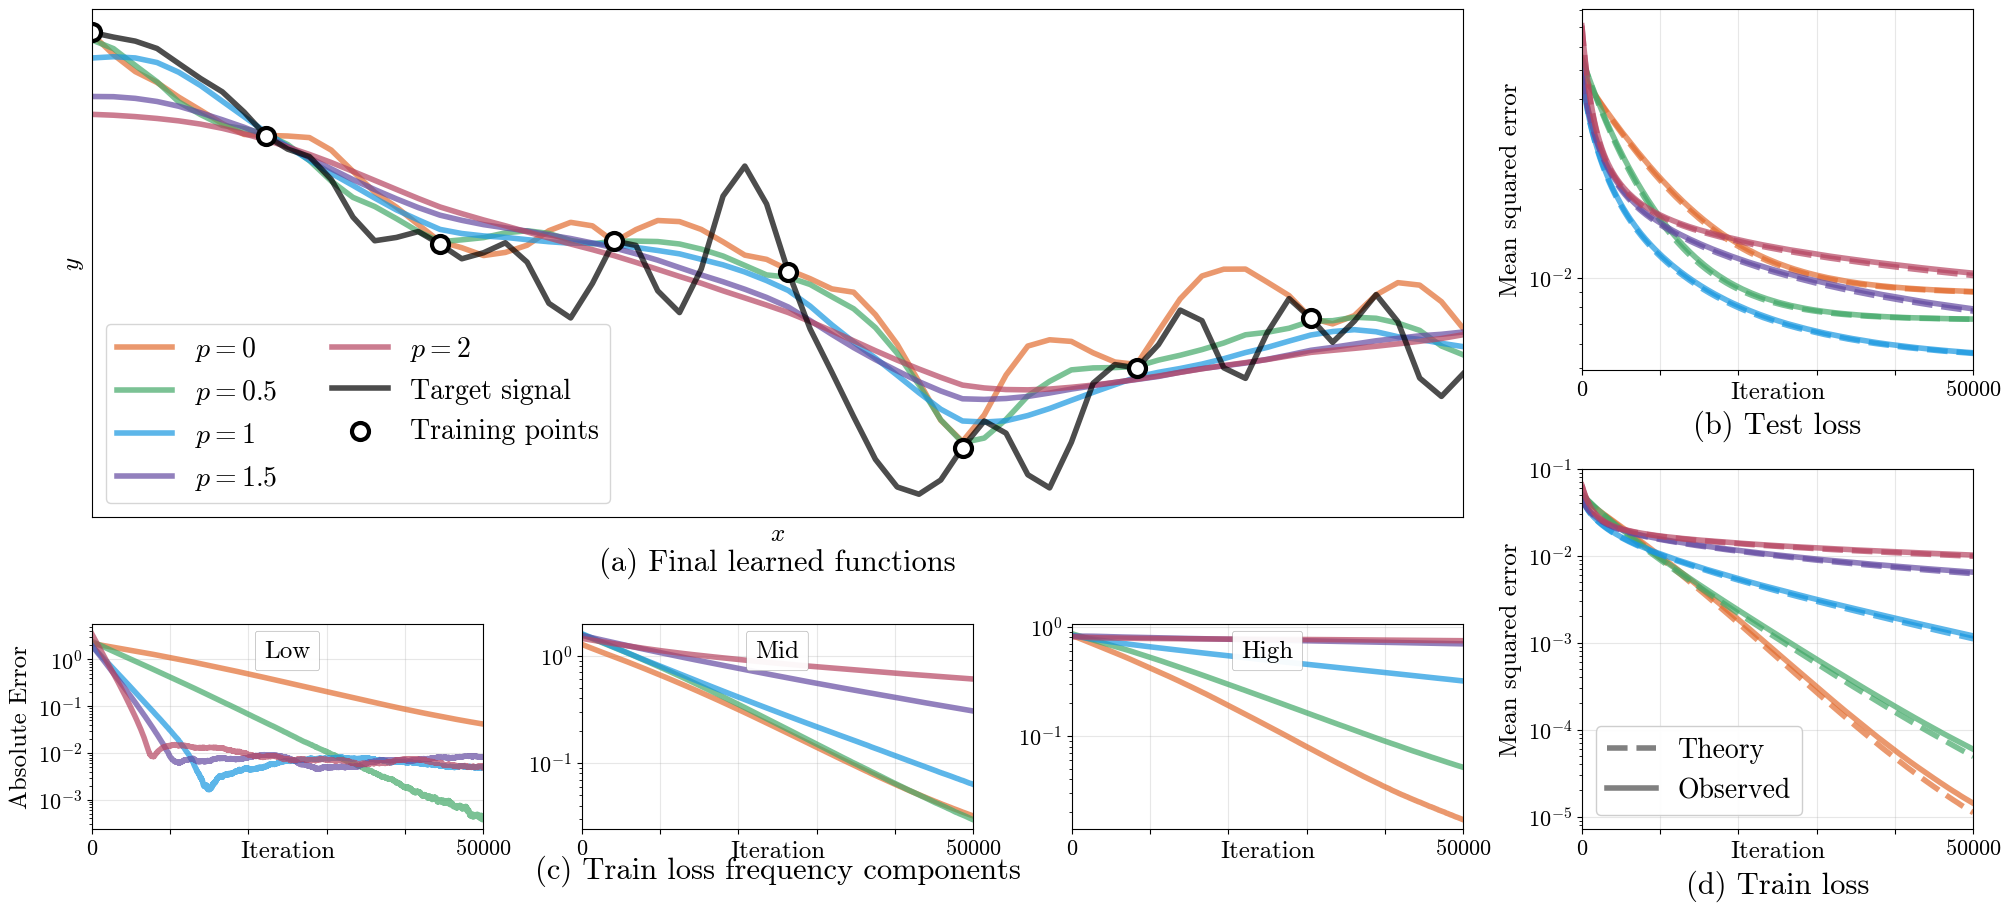

In [20]:
import matplotlib.patches as patches

prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

params = {
    "legend.fontsize": 20,
    "axes.labelsize": 18,
    "axes.titlesize": 22,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
}
pylab.rcParams.update(params)


matplotlib.rcParams["mathtext.fontset"] = "cm"
matplotlib.rcParams["mathtext.rm"] = "serif"

plt.rcParams["font.family"] = "cmr10"

names = list(outputs.keys())
names = [n for n in names if "opt" not in n]
names = [
    "$p = 0$",
    "$p = 0.5$",
    "$p = 1$",
    "$p = 1.5$",
    "$p = 2$",
    "$p = \\infty$",
    "No mapping",
]

N_kernels = len(names)
colors_k = [
    [0.8872, 0.4281, 0.1875],
    # [0.8136, 0.6844, 0.0696],
    [0.2634, 0.6634, 0.4134],
    [0.0943, 0.5937, 0.8793],
    [0.3936, 0.2946, 0.6330],
    [0.7123, 0.2705, 0.3795],
]
linewidth = 4
line_alpha = 0.7
title_offset = -0.2

xs = outputs[names[0]][-1]
t_final = learning_rate * sgd_iters

_, apply_fn, kernel_fn = make_network(*network_size)
_, apply_fn_standard, kernel_fn_standard = make_network(*network_size, ntk_params=False)
run_model = jit(
    lambda params, ab, x: np.squeeze(apply_fn(params, input_encoder(x, *ab)))
)

fig3 = plt.figure(constrained_layout=True, figsize=(20, 9))
gs = fig3.add_gridspec(6, 8)

H_rows = {
    k: compute_ntk(x_train, *ab_dict[k], kernel_fn)
    for k in names
    if k not in "No mapping"
}


### Plot learned fns
max_size = x_test.shape[0]
i0, i1 = 0.5, 0.75  ### These numbers are arbitrary, just taking a slice
i0 = (int(max_size * i0) // M) * M
i1 = (int(max_size * i1) // M) * M
ax = fig3.add_subplot(gs[0:4, 0:6])
for c, k in zip(colors_k, names):
    params = outputs[k][0]
    if k in "No mapping":
        ax.plot(
            x_test[i0:i1],
            apply_fn_standard(params, x_test[..., None] - 0.5)[i0:i1],
            label=k,
            color=c,
            linewidth=linewidth,
            alpha=line_alpha,
            zorder=1,
        )
    else:
        ax.plot(
            x_test[i0:i1],
            run_model(params, ab_dict[k], x_test)[i0:i1],
            label=k,
            color=c,
            linewidth=linewidth,
            alpha=line_alpha,
            zorder=1,
        )

plt.plot(
    x_test[i0:i1],
    s[i0:i1],
    label="Target signal",
    color="k",
    linewidth=linewidth,
    alpha=line_alpha,
    zorder=1,
)
plt.autoscale(enable=True, axis="x", tight=True)
ax.scatter(
    x_train[i0 // M : i1 // M],
    s[i0:i1:M],
    color="w",
    edgecolors="k",
    # linewidths=2,
    s=150,
    linewidth=3,
    label="Training points",
    zorder=2,
)
ax.set_title("(a) Final learned functions", y=title_offset + 0.08)
ax.set_xticks([])
ax.set_yticks([])
ax.legend(loc="lower left", ncol=2)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.grid(True, which="both", alpha=0.3)

### Plot loss curves

xvals = xs  # np.log10(np.array(xs))
ax = fig3.add_subplot(gs[3:6, 6:8])
for c, k in zip(colors_k, names):
    ax.semilogy(
        xvals,
        10 ** (np.array(outputs[k][1]) / -10),
        color=c,
        label=k,
        alpha=line_alpha,
        linewidth=linewidth,
    )
    #   if k in 'no encoding':
    #       continue
    ax.semilogy(
        xvals,
        10 ** (np.array(outputs[k][4][:, 1]) / -10),
        "--",
        color=c,
        alpha=line_alpha,
        linewidth=linewidth,
    )
plt.autoscale(enable=True, axis="x", tight=True)
ax.set_xticks([0, 10000, 20000, 30000, 40000, 50000])
ax.set_xticklabels(["$0$", "", "", "", "", "$50000$"])
plt.xlabel("Iteration", labelpad=-13)
plt.ylabel("Mean squared error")
plt.xlabel("Iteration")
ax.set_title("(d) Train loss", y=title_offset)
ax.set_ylim(top=0.1)
plt.grid(True, which="major", alpha=0.3)
custom_lines = [
    Line2D([], [], color="gray", linestyle="--", linewidth=linewidth),
    Line2D([], [], color="gray", linestyle="-", linewidth=linewidth),
]
ax.legend(
    custom_lines,
    ["Theory", "Observed"],
    loc="lower left",
    ncol=1,
    framealpha=0.95,
    handlelength=1.75,
)

ax = fig3.add_subplot(gs[0:3, 6:8])
for c, k in zip(colors_k, names):
    ax.semilogy(
        xvals,
        10 ** (np.array(outputs[k][2]) / -10),
        color=c,
        label=k,
        alpha=line_alpha,
        linewidth=linewidth,
    )
    ax.semilogy(
        xvals,
        10 ** (np.array(outputs[k][4][:, 0]) / -10),
        "--",
        color=c,
        alpha=line_alpha,
        linewidth=linewidth,
    )
plt.autoscale(enable=True, axis="x", tight=True)
ax.set_xticks([0, 10000, 20000, 30000, 40000, 50000])
ax.set_xticklabels(["$0$", "", "", "", "", "$50000$"])
plt.xlabel("Iteration", labelpad=-13)
plt.ylabel("Mean squared error")
plt.xlabel("Iteration")
ax.set_title("(b) Test loss", y=title_offset)
ax.set_yticklabels([], minor=True)
plt.grid(True, which="major", alpha=0.3)


### Plot freq components
letters = ["f", "g", "h"]
prefix = ["Low", "Mid", "High"]
for i, j in enumerate([1, 5, 15]):
    err_lines = {k: np.abs(np.fft.fft(np.array(outputs[k][3]))[:, j]) for k in names}
    ax = fig3.add_subplot(gs[4:6, 0 + 2 * i : 0 + 2 * i + 2])
    for c, k in zip(colors_k, err_lines):
        ax.semilogy(
            xs, err_lines[k], label=k, color=c, alpha=line_alpha, linewidth=linewidth
        )
    plt.autoscale(enable=True, axis="x", tight=True)
    props = dict(
        boxstyle="round,pad=0.35,rounding_size=.1",
        facecolor="white",
        edgecolor="gray",
        linewidth=0.3,
        alpha=0.95,
    )
    plt.text(
        0.5,
        0.87,
        prefix[i],
        horizontalalignment="center",
        verticalalignment="center",
        transform=ax.transAxes,
        bbox=props,
        fontsize=18,
    )
    if i == 0:
        plt.ylabel("Absolute Error")
    if i == 1:
        ax.set_title(f"(c) Train loss frequency components", y=title_offset - 0.08)
    ax.set_xticks([0, 10000, 20000, 30000, 40000, 50000])
    ax.set_xticklabels(["$0$", "", "", "", "", "$50000$"])
    plt.xlabel("Iteration", labelpad=-13)
    ax.set_yticklabels([], minor=True)
    plt.grid(True, which="major", alpha=0.3)

plt.savefig("1D_fig_supp.pdf", bbox_inches="tight", pad_inches=0)

plt.show()

# Customized

/tmp/ipykernel_3130133/3289765826.py:64: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = fig3.add_subplot(gs[0, 0])
/tmp/ipykernel_3130133/3289765826.py:107: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = fig3.add_subplot(gs[0, 1])


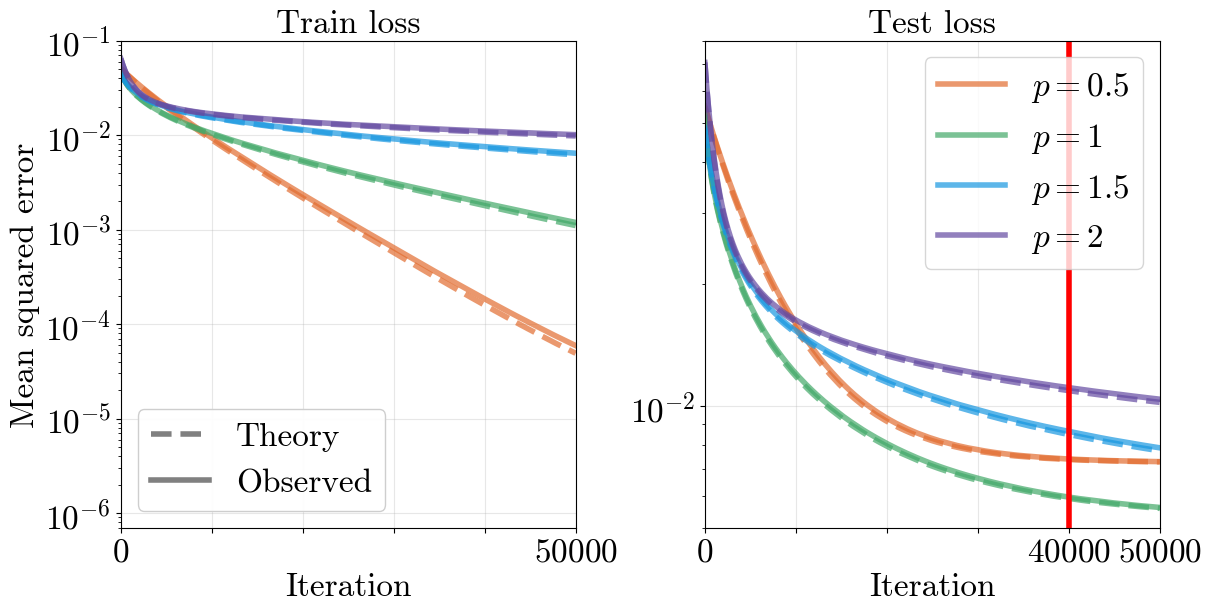

In [25]:
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

params = {
    "legend.fontsize": 24,
    "axes.labelsize": 24,
    "axes.titlesize": 24,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
}
pylab.rcParams.update(params)


matplotlib.rcParams["mathtext.fontset"] = "cm"
matplotlib.rcParams["mathtext.rm"] = "serif"

plt.rcParams["font.family"] = "cmr10"

names = list(outputs.keys())
names = [n for n in names if "opt" not in n]
names = [
    # "$p = 0$",
    "$p = 0.5$",
    "$p = 1$",
    "$p = 1.5$",
    "$p = 2$",
    # "$p = \\infty$",
    # "No mapping",
]

N_kernels = len(names)
colors_k = [
    [0.8872, 0.4281, 0.1875],
    # [0.8136, 0.6844, 0.0696],
    [0.2634, 0.6634, 0.4134],
    [0.0943, 0.5937, 0.8793],
    [0.3936, 0.2946, 0.6330],
    [0.7123, 0.2705, 0.3795],
]
linewidth = 4
line_alpha = 0.7
title_offset = -0.2

xs = outputs[names[0]][-1]
t_final = learning_rate * sgd_iters

_, apply_fn, kernel_fn = make_network(*network_size)
_, apply_fn_standard, kernel_fn_standard = make_network(*network_size, ntk_params=False)
run_model = jit(
    lambda params, ab, x: np.squeeze(apply_fn(params, input_encoder(x, *ab)))
)

fig3 = plt.figure(constrained_layout=True, figsize=(12, 6))
gs = fig3.add_gridspec(1, 2)

H_rows = {
    k: compute_ntk(x_train, *ab_dict[k], kernel_fn)
    for k in names
    if k not in "No mapping"
}

xvals = xs

ax = fig3.add_subplot(gs[0, 0])
for c, k in zip(colors_k, names):
    ax.semilogy(
        xvals,
        10 ** (np.array(outputs[k][1]) / -10),
        color=c,
        label=k,
        alpha=line_alpha,
        linewidth=linewidth,
    )
    ax.semilogy(
        xvals,
        10 ** (np.array(outputs[k][4][:, 1]) / -10),
        "--",
        color=c,
        alpha=line_alpha,
        linewidth=linewidth,
    )

plt.autoscale(enable=True, axis="x", tight=True)
ax.set_xticks([0, 10000, 20000, 30000, 40000, 50000])
ax.set_xticklabels(["$0$", "", "", "", "", "$50000$"])
# plt.xlabel("Iteration", labelpad=-13)
plt.ylabel("Mean squared error")
plt.xlabel("Iteration")
ax.set_title("Train loss")
ax.set_ylim(top=0.1)
plt.grid(True, which="major", alpha=0.3)

custom_lines = [
    Line2D([], [], color="gray", linestyle="--", linewidth=linewidth),
    Line2D([], [], color="gray", linestyle="-", linewidth=linewidth),
]
ax.legend(
    custom_lines,
    ["Theory", "Observed"],
    loc="lower left",
    ncol=1,
    framealpha=0.95,
    handlelength=1.75,
)
ax.set_ylim(7e-7, 1e-1)

ax = fig3.add_subplot(gs[0, 1])
for c, k in zip(colors_k, names):
    ax.semilogy(
        xvals,
        10 ** (np.array(outputs[k][2]) / -10),
        color=c,
        label=k,
        alpha=line_alpha,
        linewidth=linewidth,
    )
    ax.semilogy(
        xvals,
        10 ** (np.array(outputs[k][4][:, 0]) / -10),
        "--",
        color=c,
        alpha=line_alpha,
        linewidth=linewidth,
    )
ax.vlines(x=40000, ymin=0, ymax=1, colors="red", linewidth=linewidth)
ax.legend()

plt.autoscale(enable=True, axis="x", tight=True)
ax.set_xticks([0, 10000, 20000, 30000, 40000, 50000])
ax.set_xticklabels(["$0$", "", "", "", "$40000$", "$50000$"])
# plt.xlabel("Iteration", labelpad=-13)
# plt.ylabel("Mean squared error")
plt.xlabel("Iteration")
ax.set_title("Test loss")
ax.set_ylim(5e-3, 8e-2)
# ax.set_yticklabels([], minor=True)
plt.grid(True, which="major", alpha=0.3)

plt.savefig("1d_loss_ori.pdf", bbox_inches="tight")
plt.show()

In [22]:
# # save original
# k = "$p = 0$"
# params = outputs[k][0]
# np.save("./1d_regression_results/original/line_x.npy", x_test[i0:i1])
# np.save(
#     "./1d_regression_results/original/line_y.npy",
#     run_model(params, ab_dict[k], x_test)[i0:i1],
# )